<a href="https://colab.research.google.com/github/MahamadouNiakate/crypto_pred/blob/master/Notebooks/DBD_Crypto_Monthly_2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Data Import

In [1]:
# !pip install yfinance
# !pip install catboost
# ! pip install --pre pycaret
# !pip install pycaret
# !pip install markupsafe==2.0.1
# !pip install Jinja2

In [2]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb
# import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [3]:
btc_ticker = yf.Ticker('BTC-USD')
# btc = btc_ticker.history(period="max")
today = datetime.today().strftime('%Y-%m-%d')
btc = btc_ticker.history(start='2017-01-01', end=today)
btc = btc.drop(columns=['Dividends', 'Stock Splits'])

In [4]:
btc.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008


# Data Preparation

In [5]:
monthly_close = btc.groupby(btc.index.month)['Close'].tail(1)

In [6]:
# btc.resample('M', origin='end').mean().tail(10)

In [7]:
month_close_df = btc.copy()[btc.index.is_month_end]
month_close_df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

month_close_df.rename(columns={'Close':'month_close'}, inplace=True)


month_close_df

,month_close
Date,
2017-01-31,970.403015
2017-02-28,1179.969971
2017-03-31,1071.790039
2017-04-30,1347.890015
2017-05-31,2286.409912
...,...
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562


In [8]:
btc_month_mean = btc.resample('M').mean()
btc_month_mean.rename(columns={'Open':'month_ave_open', 'High':'month_ave_high', 'Low':'month_ave_low', 'Close':'month_ave_close', 'Volume':'month_ave_volume'}, inplace=True)
btc_month_mean.tail()


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume
Date,,,,,
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10
2022-09-30,19993.509766,20133.563672,19695.390625,19945.616797,2.739568e+10


In [9]:
btc_month_mean['month_ave_close_shift'] = btc_month_mean['month_ave_close'].shift(-1)
# btc_month_mean.dropna(inplace=True)
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift
Date,,,,,,
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346
...,...,...,...,...,...,...
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318


In [10]:
# btc_month_mean['month_ave_close_shift'].hist()

In [11]:
btc_month_mean['month_ave_close_shift_diff'] = btc_month_mean['month_ave_close_shift'].diff()
btc_month_mean.dropna(inplace=True)
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff
Date,,,,,,,
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960
...,...,...,...,...,...,...,...
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639


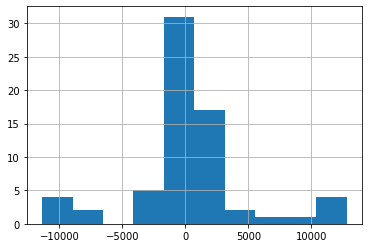

In [12]:
btc_month_mean['month_ave_close_shift_diff'].hist()

Dickey–Fuller test: p=0.000004


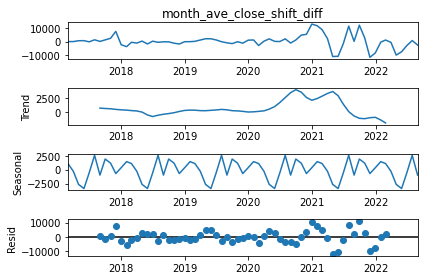

In [13]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff'])[1])

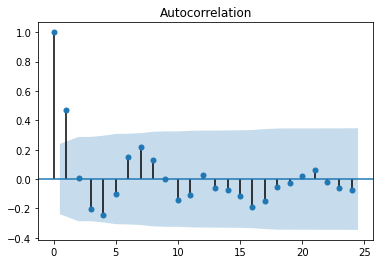

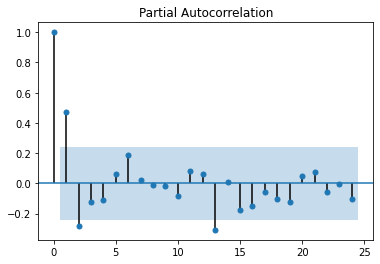

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(btc_month_mean['month_ave_close_shift_diff'], lags=24);
plot_pacf(btc_month_mean['month_ave_close_shift_diff'], lags=24);

In [15]:
# btc_month_mean.head(20)


In [16]:
btc_month_mean['month_ave_close_shift_diff_percent'] = None

for i in range(1, len(btc_month_mean)):
  btc_month_mean['month_ave_close_shift_diff_percent'][i] = \
  (btc_month_mean['month_ave_close_shift'][i] - btc_month_mean['month_ave_close_shift'][i-1]) / btc_month_mean['month_ave_close_shift'][i-1]

btc_month_mean.dropna(inplace=True)
btc_month_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
...,...,...,...,...,...,...,...,...
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653


!! Stationary

Dickey–Fuller test: p=0.000007


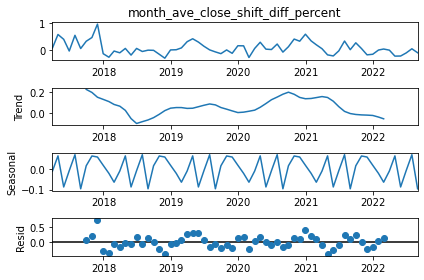

In [17]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff_percent']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff_percent'])[1])

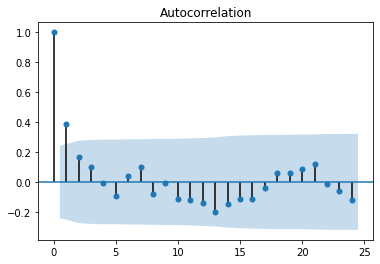

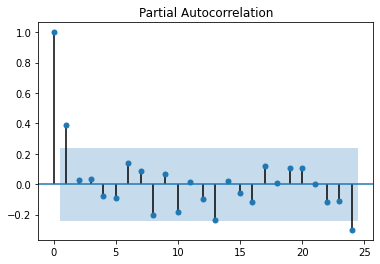

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);
plot_pacf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);

## Train/Test Split + Scale Data

In [19]:
train_test_split = int(btc_month_mean.shape[0] * 0.75)
train = btc_month_mean.copy().iloc[:train_test_split]
test = btc_month_mean.copy().iloc[train_test_split:]
train.shape, test.shape

((49, 8), (17, 8))

In [20]:
train.columns

Index(['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close',
       'month_ave_volume', 'month_ave_close_shift',
       'month_ave_close_shift_diff', 'month_ave_close_shift_diff_percent'],
      dtype='object')

In [21]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

#hide warnings
train_scaled = pd.DataFrame()
test_scaled = pd.DataFrame()

train_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.fit_transform(train[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])
test_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.transform(test[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])

train_scaled.index = train.index
test_scaled.index = test.index

display(train_scaled.head())
display(test_scaled.tail())

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2017-03-31,0.000000,0.000000,0.000000,0.000316,0.000000,0.299727
2017-04-30,0.001206,0.000988,0.001707,0.000000,0.001435,0.695410
2017-05-31,0.013715,0.014647,0.013731,0.009672,0.014220,0.553685
2017-06-30,0.028034,0.028143,0.027729,0.014351,0.027972,0.210942
2017-07-31,0.025762,0.026178,0.025561,0.009015,0.025804,0.671496


,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2022-04-30,0.759414,0.747266,0.765561,0.339084,0.748227,0.060894
2022-05-31,0.576047,0.571215,0.574680,0.438246,0.567617,0.063933
2022-06-30,0.442791,0.436870,0.436763,0.377865,0.431686,0.153954
2022-07-31,0.379909,0.378483,0.382905,0.367003,0.378883,0.276076
2022-08-31,0.399514,0.394066,0.404435,0.353647,0.394235,0.160591


In [22]:
X_train = train_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_train = train_scaled.copy()['month_ave_close_shift_diff_percent']

X_test = test_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_test = test_scaled.copy()['month_ave_close_shift_diff_percent']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((49, 5), (49,), (17, 5), (17,))

In [23]:
X_train.head(20)

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close
Date,,,,,
2017-03-31,0.000000,0.000000,0.000000,0.000316,0.000000
2017-04-30,0.001206,0.000988,0.001707,0.000000,0.001435
2017-05-31,0.013715,0.014647,0.013731,0.009672,0.014220
2017-06-30,0.028034,0.028143,0.027729,0.014351,0.027972
2017-07-31,0.025762,0.026178,0.025561,0.009015,0.025804
2017-08-31,0.050300,0.050668,0.050509,0.021386,0.051080
2017-09-30,0.055123,0.055410,0.054106,0.018990,0.054493
2017-10-31,0.077851,0.077845,0.078598,0.019171,0.078537
2017-11-30,0.122680,0.125654,0.122998,0.054138,0.124075


In [24]:
y_train.head(20)

Date
2017-03-31    0.299727
2017-04-30    0.695410
2017-05-31    0.553685
2017-06-30    0.210942
2017-07-31    0.671496
2017-08-31    0.283145
2017-09-30    0.496809
2017-10-31    0.606299
2017-11-30    1.000000
2017-12-31    0.132089
2018-01-31    0.028331
2018-02-28    0.209958
2018-03-31    0.158106
2018-04-30    0.286757
2018-05-31    0.091356
2018-06-30    0.286743
2018-07-31    0.196654
2018-08-31    0.235319
2018-09-30    0.230875
2018-10-31    0.114560
Freq: M, Name: month_ave_close_shift_diff_percent, dtype: float64

# LinearRegression (static window)

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train) 
lr.score(X_train, y_train) 

0.45565867455653175

In [26]:
X_test_predict = lr.predict(X_test)

X_test_predict_df = pd.DataFrame(X_test_predict, index=X_test.index, columns=['Y_PRED'])
X_test_predict_df

,Y_PRED
Date,
2021-04-30,-0.826098
2021-05-31,-1.537758
2021-06-30,-0.329982
2021-07-31,0.109161
2021-08-31,-0.186005
2021-09-30,-0.723483
2021-10-31,0.273016
2021-11-30,-1.397626
2021-12-31,-1.425025


## Reassemble data frame with prediction

In [27]:
predict_df = test.merge(X_test_predict_df, how='left', on='Date')
predict_df

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.826098
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-1.537758
2021-06-30,35920.546940,37094.880143,34375.803060,35845.154687,3.965492e+10,34444.973790,-1400.180897,-0.039062,-0.329982
2021-07-31,34234.212450,35161.966356,33430.565020,34444.973790,2.642269e+10,45709.022681,11264.048891,0.327016,0.109161
2021-08-31,45516.119834,46685.621346,44464.354587,45709.022681,3.273143e+10,45939.771484,230.748803,0.005048,-0.186005
2021-09-30,46041.859375,47132.725000,44643.686328,45939.771484,3.673799e+10,57911.970514,11972.199030,0.260606,-0.723483
2021-10-31,57344.743952,59024.878150,56183.983115,57911.970514,3.719606e+10,60621.488802,2709.518288,0.046787,0.273016
2021-11-30,60857.520312,62046.720703,59290.196615,60621.488802,3.510901e+10,49263.209173,-11358.279629,-0.187364,-1.397626
2021-12-31,49670.411794,50722.471018,48108.254914,49263.209173,3.087249e+10,41114.422379,-8148.786794,-0.165413,-1.425025


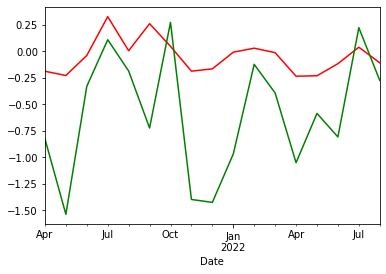

In [28]:
predict_df['month_ave_close_shift_diff_percent'].plot(c='red')
predict_df['Y_PRED'].plot(c='green')

In [29]:
#merge actual close with the dataframe
# predict_df = predict_df.merge(month_close_df, how='left', left_index=True, right_index=True)
predict_df


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.826098
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-1.537758
2021-06-30,35920.546940,37094.880143,34375.803060,35845.154687,3.965492e+10,34444.973790,-1400.180897,-0.039062,-0.329982
2021-07-31,34234.212450,35161.966356,33430.565020,34444.973790,2.642269e+10,45709.022681,11264.048891,0.327016,0.109161
2021-08-31,45516.119834,46685.621346,44464.354587,45709.022681,3.273143e+10,45939.771484,230.748803,0.005048,-0.186005
2021-09-30,46041.859375,47132.725000,44643.686328,45939.771484,3.673799e+10,57911.970514,11972.199030,0.260606,-0.723483
2021-10-31,57344.743952,59024.878150,56183.983115,57911.970514,3.719606e+10,60621.488802,2709.518288,0.046787,0.273016
2021-11-30,60857.520312,62046.720703,59290.196615,60621.488802,3.510901e+10,49263.209173,-11358.279629,-0.187364,-1.397626
2021-12-31,49670.411794,50722.471018,48108.254914,49263.209173,3.087249e+10,41114.422379,-8148.786794,-0.165413,-1.425025


### append_gain_loss

In [30]:
#temp
month_close_df.tail()

,month_close
Date,
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562
2022-07-31,23336.896484
2022-08-31,20049.763672


In [31]:
#hide chain warning
pd.options.mode.chained_assignment = None

In [32]:
def append_gain_loss(df, debug=False):

  df = df.merge(month_close_df, how='left', left_index=True, right_index=True)
  if debug:
    display(df.tail())

  df['gain_loss'] = None
  df['gain_loss_percent'] = None
  for i in range(1, len(df)):

    df['gain_loss'][i] = df['month_close'][i] - df['month_close'][i-1]
    df['gain_loss_percent'][i] = ((df['month_close'][i] - df['month_close'][i-1])/((df['month_close'][i]+df['month_close'][i-1])/2))
    
    
    df['month_close'][i]/((df['month_close'][i] - df['month_close'][i-1]))
  df.dropna(inplace=True)
  return df

predict_df = append_gain_loss(predict_df)


In [33]:
predict_df.tail()

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED,month_close,gain_loss,gain_loss_percent
Date,,,,,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805,-1.050942,37714.875000,-7823.800781,-0.187951
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947,-0.586095,31792.310547,-5922.564453,-0.170416
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653,-0.807885,19784.726562,-12007.583984,-0.465617
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396,0.223023,23336.896484,3552.169922,0.164751
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,19945.616797,-2420.649521,-0.108228,-0.274144,20049.763672,-3287.132812,-0.151527


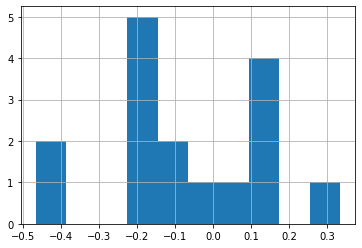

In [34]:
predict_df['gain_loss_percent'].hist(bins=10)

## Evaluate strategy

### if Y_PRED > 0

In [67]:
def calc_gain_loss(df, threshold, column, debug=False):

  gain_loss = []
  for index, row in df.iterrows():
    if row[column] > threshold:
      if debug:
        print(f'{index}::{row[column]}')

      # gain_loss.append(row['Close_shift'] - row['Close'])
      gain_loss.append(row['gain_loss'])
      
  if debug:
    display(gain_loss)
    print(f'GAIN/LOSS: {sum(gain_loss)}')
    
  return sum(gain_loss)  

In [68]:
gain_loss = calc_gain_loss(predict_df, 0.0, 'Y_PRED', False)
print(f'gain_loss: {gain_loss}')

gain_loss: 27665.591796875


In [69]:
def calc_gain_loss_2(df, threshold, column, investment_amount, debug=False):

  gain_loss = []
  
  for index, row in df.iterrows():
    if row[column] > threshold:
      if debug:
        print(f'{index}::{row[column]}::{row["gain_loss_percent"]}')

      # gain_loss.append(row['Close_shift'] - row['Close'])
      gain_loss.append(investment_amount * row['gain_loss_percent'])
      
  if debug:
    # print('A----gain_loss ------')
    # display(gain_loss)
    # print('Z----gain_loss ------')
    print(f'GAIN/LOSS: {sum(gain_loss)}')
    
  return sum(gain_loss)

In [70]:
gain_loss_100 = calc_gain_loss_2(predict_df, 0.0, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss_100: 67.00613108601863


In [71]:
predict_df.tail()


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED,month_close,gain_loss,gain_loss_percent
Date,,,,,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805,-1.050942,37714.875000,-7823.800781,-0.187951
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947,-0.586095,31792.310547,-5922.564453,-0.170416
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653,-0.807885,19784.726562,-12007.583984,-0.465617
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396,0.223023,23336.896484,3552.169922,0.164751
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,19945.616797,-2420.649521,-0.108228,-0.274144,20049.763672,-3287.132812,-0.151527


### if Y_PRED > .1


In [72]:
gain_loss = calc_gain_loss(predict_df, 0.1, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(predict_df, 0.1, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 27665.591796875
gain_loss_100: 67.00613108601863


### if Y_PRED > .20

In [73]:
gain_loss = calc_gain_loss(predict_df, 0.2, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(predict_df, 0.2, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 21080.232421875
gain_loss_100: 49.82701441062238


In [74]:
predict_df.shape

(16, 12)

In [75]:
#find residuals and P values
from statsmodels.api import OLS

ols = OLS(y_train, X_train).fit()

In [76]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     month_ave_close_shift_diff_percent   R-squared (uncentered):                   0.491
Model:                                            OLS   Adj. R-squared (uncentered):              0.434
Method:                                 Least Squares   F-statistic:                              8.506
Date:                                Tue, 06 Sep 2022   Prob (F-statistic):                    1.07e-05
Time:                                        19:32:25   Log-Likelihood:                         -6.5291
No. Observations:                                  49   AIC:                                      23.06
Df Residuals:                                      44   BIC:                                      32.52
Df Model:                                           5                                                  
Covariance Type:                            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
month_ave_open    -155.3313     63.599     -2.442      0.019    -283.506     -27.156
month_ave_high     178.0733     85.759      2.076      0.044       5.238     350.908
month_ave_low      139.5258     59.339      2.351      0.023      19.937     259.115
month_ave_volume     0.5067      0.299      1.697      0.097      -0.095       1.108
month_ave_close   -161.9661     93.580     -1.731      0.090    -350.564      26.632
==============================================================================
Omnibus:                        2.325   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.540
Skew:                          -0.080   Prob(JB):                        0.463
Kurtosis:                       3.853   Cond. No.                     2.05e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

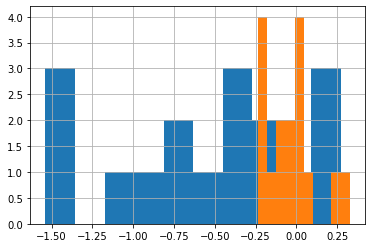

In [77]:
predict_df['Y_PRED'].hist()
predict_df['month_ave_close_shift_diff_percent'].hist()

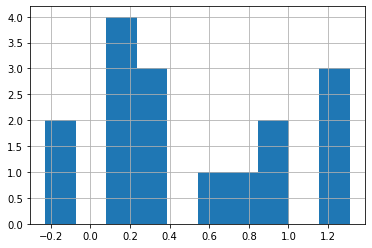

In [78]:
(predict_df['month_ave_close_shift_diff_percent']-predict_df['Y_PRED']).hist()

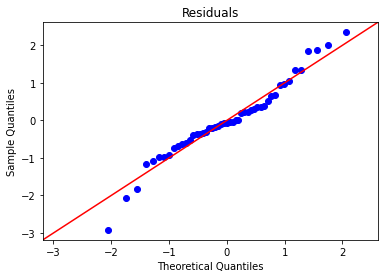

In [79]:
sm.qqplot(ols.resid, fit=True, line='45')
plt.title('Residuals')
plt.show()

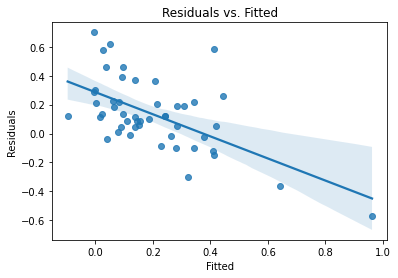

In [80]:
sns.regplot(x=ols.fittedvalues, y=ols.resid)
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Linear Regression (Sliding 'X' month window)


In [81]:
btc_month_mean.tail()

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,19945.616797,-2420.649521,-0.108228


In [82]:
def calc_sliding_window(window_size, input_df, debug=False):
  predict_df = pd.DataFrame(columns=['Y_PRED'])
  # btc_month_mean.shape

  for i in range(window_size, input_df.shape[0]+1):

    window_data = input_df[i-window_size:i]
    if debug:
      print(f'{i-window_size}->{i}')
      display(window_data)

    X = window_data.copy()[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close', 'month_ave_volume']]

    X_train = X[:X.shape[0]-1]
    X_pred = X[X.shape[0]-1:]

    y = window_data['month_ave_close_shift_diff_percent']
    y_train = y[:X.shape[0]-1]

    lr = LinearRegression()
    lr.fit(X_train, y_train) 
    y_pred = lr.predict(X_pred)[0]

    y_pred_df = pd.DataFrame(data=[y_pred], columns=['Y_PRED'], index=[X_pred.index[0]])
    predict_df = pd.concat([predict_df, pd.DataFrame(y_pred_df)], ignore_index=False)

  return predict_df

In [83]:
# test_df = calc_sliding_window(48, btc_month_mean, False)
# test_df

# test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0, 'Y_PRED', False)
# print(f'gain_loss: {gain_loss}')

# gain_loss_100 = calc_gain_loss_2(test_df, 0.0, 'Y_PRED', 100, False)
# print(f'gain_loss_100: {gain_loss_100}')


In [84]:
test_df = calc_sliding_window(48, btc_month_mean, False)
test_df

test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0.33, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(test_df, 0.33, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 17528.0625
gain_loss_100: 33.351892785382795


In [85]:
test_df = calc_sliding_window(48, btc_month_mean, False)
test_df

test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0.5, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(test_df, 0.5, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 17528.0625
gain_loss_100: 33.351892785382795


In [86]:
# predict_df = append_gain_loss(predict_df)

In [87]:
gain_loss = calc_gain_loss(predict_df, 0, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(predict_df, 0.0, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 27665.591796875
gain_loss_100: 67.00613108601863


In [88]:
gain_loss = calc_gain_loss(predict_df, 0.1, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(predict_df, 0.1, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 27665.591796875
gain_loss_100: 67.00613108601863


In [89]:
gain_loss = calc_gain_loss(predict_df, 0.2, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss_100 = calc_gain_loss_2(predict_df, 0.2, 'Y_PRED', 100, False)
print(f'gain_loss_100: {gain_loss_100}')

gain_loss: 21080.232421875
gain_loss_100: 49.82701441062238


## Loop over window size and gain % options

In [90]:
window_sizes = [3, 6, 12]#, 24, 36, 48, 60, 72]
gain_percents = [0, .05, .1]#, .2, .3]

result_df = pd.DataFrame(columns=['window', 'percent', 'gain_loss'])

bet_size = 50
for window_size in window_sizes:
  for gain_percent in gain_percents:

    test_df = calc_sliding_window(window_size, btc_month_mean, False)

    test_df = append_gain_loss(test_df)
    gain_loss = calc_gain_loss(test_df, gain_percent, 'Y_PRED')

    gain_loss_bet_size = calc_gain_loss_2(test_df, gain_percent, 'Y_PRED', bet_size, False)
    print(f'gain_loss_{bet_size} {gain_loss_bet_size}')

    loop_df = pd.DataFrame(data=[[window_size, gain_percent, gain_loss, gain_loss_bet_size]], columns=['window', 'percent', 'gain_loss', f'gain_loss_{bet_size}'])
    result_df = pd.concat([result_df, loop_df], ignore_index=True)

result_df

gain_loss_50 187.85209293862553
gain_loss_50 167.74216857942707
gain_loss_50 148.54056135108004
gain_loss_50 142.53333365375644
gain_loss_50 151.72508501493883
gain_loss_50 136.95033093835178
gain_loss_50 114.82703982251917
gain_loss_50 145.54934701499707
gain_loss_50 126.3218931956028


,window,percent,gain_loss,gain_loss_50
0,3,0,86022.621826,187.852093
1,3,0.05,77828.557373,167.742169
2,3,0.1,69355.705322,148.540561
3,6,0,40342.951904,142.533334
4,6,0.05,41598.099365,151.725085
5,6,0.1,34631.585449,136.950331
6,12,0,67321.333740,114.827040
7,12,0.05,80373.861328,145.549347
8,12,0.1,57280.697266,126.321893


In [91]:
result_df.sort_values('gain_loss', ascending=False)

,window,percent,gain_loss,gain_loss_50
0,3,0,86022.621826,187.852093
7,12,0.05,80373.861328,145.549347
1,3,0.05,77828.557373,167.742169
2,3,0.1,69355.705322,148.540561
6,12,0,67321.333740,114.827040
8,12,0.1,57280.697266,126.321893
4,6,0.05,41598.099365,151.725085
3,6,0,40342.951904,142.533334
5,6,0.1,34631.585449,136.950331


In [92]:
window_sizes = [3]
gain_percents = [0, .05, .1]

result_df = pd.DataFrame(columns=['window', 'percent', 'gain_loss'])
bet_size = 100

for window_size in window_sizes:
  for gain_percent in gain_percents:

    test_df = calc_sliding_window(window_size, btc_month_mean, False)

    test_df = append_gain_loss(test_df)
    gain_loss = calc_gain_loss(test_df, gain_percent, 'Y_PRED')


    gain_loss_bet_size = calc_gain_loss_2(test_df, gain_percent, 'Y_PRED', bet_size, False)
    print(f'gain_loss_{bet_size} {gain_loss_bet_size}')

    loop_df = pd.DataFrame(data=[[window_size, gain_percent, gain_loss, gain_loss_bet_size]], columns=['window', 'percent', 'gain_loss', f'gain_loss_{bet_size}'])

    # loop_df = pd.DataFrame(data=[[window_size, gain_percent, gain_loss]], columns=['window', 'percent', 'gain_loss'])
    result_df = pd.concat([result_df, loop_df], ignore_index=True)

result_df.sort_values('gain_loss', ascending=False)

gain_loss_100 375.70418587725106
gain_loss_100 335.48433715885415
gain_loss_100 297.0811227021601


,window,percent,gain_loss,gain_loss_100
0,3,0,86022.621826,375.704186
1,3,0.05,77828.557373,335.484337
2,3,0.1,69355.705322,297.081123


### Do look forward predictions

# Multiple Regression Models (Sliding 'X' month window)


In [93]:
def calc_sliding_window2(model_name, model, window_size, input_df, debug=False):
  predict_df = pd.DataFrame(columns=['Y_PRED'])
  # btc_month_mean.shape

  for i in range(window_size, input_df.shape[0]+1):

    window_data = input_df[i-window_size:i]
    if debug:
      print(f'{i-window_size}->{i}')
      display(window_data)

    X = window_data.copy()[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close', 'month_ave_volume']]

    X_train = X[:X.shape[0]-1]
    X_pred = X[X.shape[0]-1:]

    y = window_data['month_ave_close_shift_diff_percent']
    y_train = y[:X.shape[0]-1]

    model.fit(X_train, y_train) 
    y_pred = model.predict(X_pred)[0]

    y_pred_df = pd.DataFrame(data=[[model_name, y_pred]], columns=['model_name', 'Y_PRED'], index=[X_pred.index[0]])
    predict_df = pd.concat([predict_df, pd.DataFrame(y_pred_df)], ignore_index=False)

  return predict_df

In [ ]:
window_sizes = [3, 6, 12]#, 24, 36, 48, 60, 72]
gain_percents = [0, .05, .1]#, .2, .3]
model_list = [('lr', LinearRegression()), ('xgb', xgb.XGBRegressor(objective ='reg:squarederror')), ('knn', KNeighborsRegressor(n_neighbors=2)), ('rf', RandomForestRegressor()) ]#('cb', cb.CatBoostRegressor())

bet_size=100
result_df = pd.DataFrame(columns=['window', 'percent', 'gain_loss', f'gain_loss_{bet_size}'])

for window_size in window_sizes:
  for gain_percent in gain_percents:
    for model_name, model in model_list:
      # print(f'model_name: {model_name}')

      test_df = calc_sliding_window2(model_name, model, window_size, btc_month_mean, False)

      test_df = append_gain_loss(test_df)
      gain_loss = calc_gain_loss(test_df, gain_percent, 'Y_PRED')
      
      gain_loss_bet_size = calc_gain_loss_2(test_df, gain_percent, 'Y_PRED', bet_size, False)
      print(f'gain_loss_{bet_size} {gain_loss_bet_size}')

      loop_df = pd.DataFrame(data=[[window_size, gain_percent, gain_loss, gain_loss_bet_size]], columns=['window', 'percent', 'gain_loss', f'gain_loss_{bet_size}'])
      # loop_df = pd.DataFrame(data=[[window_size, gain_percent, gain_loss, model_name]], columns=['window', 'percent', 'gain_loss', 'model_name'])

      result_df = pd.concat([result_df, loop_df], ignore_index=True)

sorted = result_df.sort_values('gain_loss', ascending=False)
sorted.head(30)

gain_loss_100 375.70418587725106
gain_loss_100 294.88130422582526
gain_loss_100 461.49093227085405
gain_loss_100 399.0299357807759
gain_loss_100 335.48433715885415
gain_loss_100 359.9821642949772
gain_loss_100 396.869887487104
gain_loss_100 409.46466541507647
gain_loss_100 297.0811227021601
gain_loss_100 365.81820370053856
gain_loss_100 409.46466541507647
gain_loss_100 375.72533202396767
gain_loss_100 285.0666673075129
gain_loss_100 240.823901041723
gain_loss_100 303.857467258927
gain_loss_100 267.1207173641519
gain_loss_100 303.45017002987765
gain_loss_100 248.97667015468846
gain_loss_100 271.48537974950403
gain_loss_100 202.23882110951502
gain_loss_100 273.90066187670357
gain_loss_100 215.5201779171913
gain_loss_100 309.4754781225863
gain_loss_100 238.251148345711
gain_loss_100 229.65407964503834
gain_loss_100 210.9236780628164
gain_loss_100 124.7585382859369
gain_loss_100 77.276489719704
gain_loss_100 291.09869402999414
gain_loss_100 243.9195144852609
gain_loss_100 149.7421954995508